# 1. Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
plt.style.use('ggplot')

# 2. Load Data, Summary

In [ ]:
path = "../input/train.csv"
train = pd.read_csv(path)
train.head()

In [3]:
train.shape

(913000, 4)

In [4]:
train["year"] = pd.to_datetime(train["date"]).dt.year
train["month"] = pd.to_datetime(train["date"]).dt.month
train["month_year"] = pd.to_datetime(train["date"]).dt.to_period('M')
train.head()

,date,store,item,sales,year,month,month_year
0,2013-01-01,1,1,13,2013,1,2013-01
1,2013-01-02,1,1,11,2013,1,2013-01
2,2013-01-03,1,1,14,2013,1,2013-01
3,2013-01-04,1,1,13,2013,1,2013-01
4,2013-01-05,1,1,10,2013,1,2013-01


# 3. Missing Values

In [5]:
# train.count() will give a value only if not nan
count_nan = len(train) - train.count()
count_nan

date          0
store         0
item          0
sales         0
year          0
month         0
month_year    0
dtype: int64

# 4. Individual Feature Visualization

## 4.1 Histogram of sales of an item (daily sales amount)
#"histogram of daily sales price" but I believe it's actually sales quantity. 

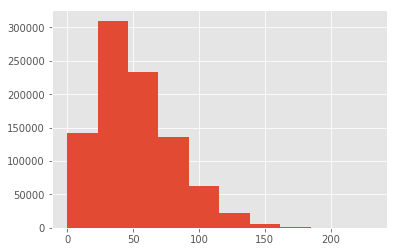

In [6]:
plt.hist(train["sales"])
plt.show()

Sales is positively skewed.

## 4.2 "Growth" (?) of sales price by date and change of rate of sales price

In [7]:
# R script: MSP <- aggregate(sales ~date, train, mean)
mean_sales = train.groupby(["date"], as_index=False)
mean_sales = mean_sales[["sales"]].mean()
mean_sales["idx"] = mean_sales.index

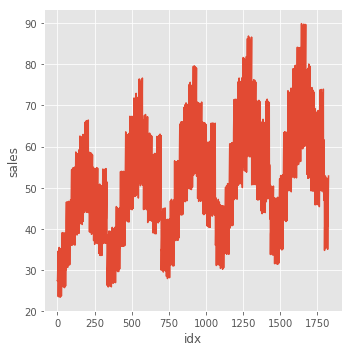

In [8]:
# Could use the follow:
# plt.scatter(x=mean_sales["date"], y=mean_sales["sales"])
# plt.show()
# Seaborn gives us a closer analogue to the work done in R.
g = sns.relplot(x="idx", y="sales", data=mean_sales, kind="line")

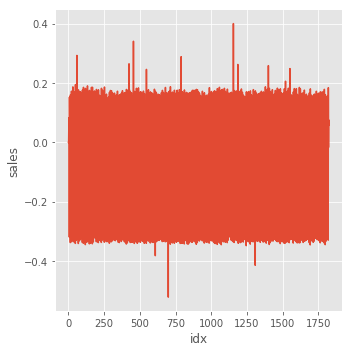

In [9]:
# Change in rate of sales
# R script: MSP$rate = c(0, 100*diff(MSP$sales)/MSP[-nrow(MSP),]$sales)
# plt.scatter(x=mean_sales.index, y=rt)
# plt.show()
# rt is short form for "Rate"
rt = pd.Series(mean_sales["sales"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="sales", x="idx", data=rt, kind="line")

You can see that sales growth is multiplicative with increasing trend and seasonality.

# 4.3 Sales growth monthly

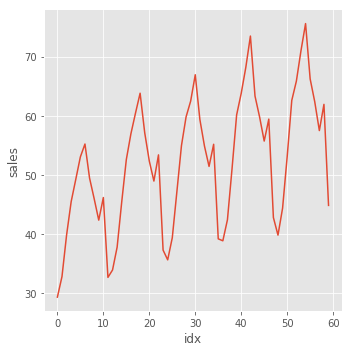

In [10]:
# R script: MSP <- aggregate(sales ~<Month, train, mean)
# plt.scatter(x=mean_sales_monthly.index, y=mean_sales_monthly["sales"])
# plt.show()
# Used index instead of month-year values 
# because matplotlib complains otherwise
mean_sales_monthly = train.groupby(["month_year"], as_index=False)
mean_sales_monthly = mean_sales_monthly[["sales"]].mean()
mean_sales_monthly["idx"] = mean_sales_monthly.index
g = sns.relplot(y="sales", x="idx", data=mean_sales_monthly, kind="line")

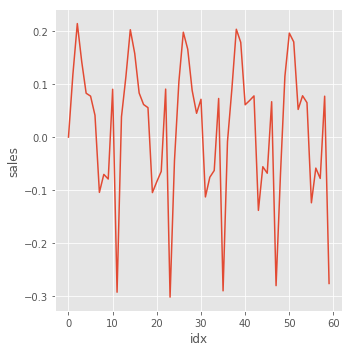

In [11]:
# Change in rate of sales
# R script: MSP$rate = c(0, 100*diff(MSP$sales)/MSP[-nrow(MSP),]$sales)
# rt = pd.Series(mean_sales_monthly["sales"]).pct_change()
rt = pd.Series(mean_sales_monthly["sales"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="sales", x="idx", data=rt, kind="line")

We can confirm that sales are multipliative with increasing trend and seasonality.

# 4.4 Growth by Year

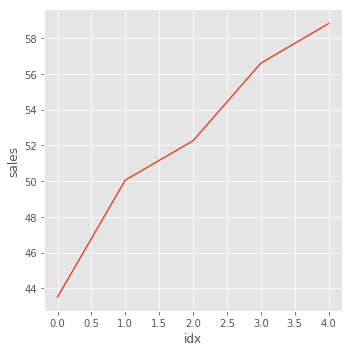

In [12]:
# R script: MSP <- aggregate(sales ~Year, train, mean)
#plt.scatter(x=mean_sales_yearly.year, y=mean_sales_yearly["sales"])
#plt.show()
mean_sales_yearly = train.groupby(["year"], as_index=False)
mean_sales_yearly = mean_sales_yearly[["sales"]].mean()
mean_sales_yearly["idx"] = mean_sales_yearly.index
g = sns.relplot(y="sales", x="idx", data=mean_sales_yearly, kind="line")

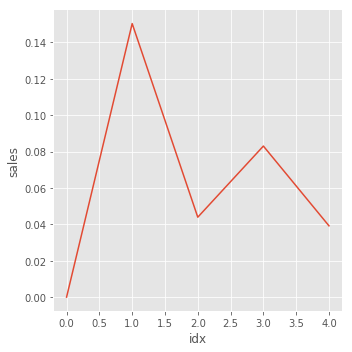

In [13]:
# Change in rate of sales
# R script: MSP$rate = c(0, 100*diff(MSP$sales)/MSP[-nrow(MSP),]$sales)
#plt.scatter(x=mean_sales_yearly.year, y=rt)
#plt.show()
rt = pd.Series(mean_sales_yearly["sales"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="sales", x="idx", data=rt, kind="line")

Growth of sales increases yearly, but the change in sales is different per year. Rate of change of sales decreased from 2014 to 2015, increased to 2016, then dropped.

# 4.5 Sales growth by store

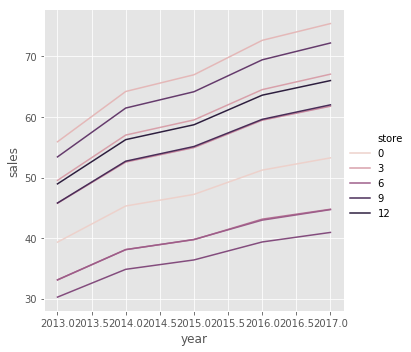

In [14]:
#unique(train$store)
#Year_state<-aggregate(sales ~store+Year, train,mean)
#pal<-rep(brewer.pal(10, "BrBG"),5)
#stores = pd.unique(train["store"])
#years_stores = train.groupby(["year", "store"], as_index=False)
#years_stores = years_stores[["sales"]].mean()
#plt.scatter(x=years_stores["sales"],y=years_stores["store"])
data = train.groupby(['store',"year"])
mean = data[["sales"]].mean()
mean = mean.add_suffix('').reset_index()
g = sns.relplot(y="sales", x="year", data=mean, kind="line", hue="store")

# 4.6 Yearly Growth by Item

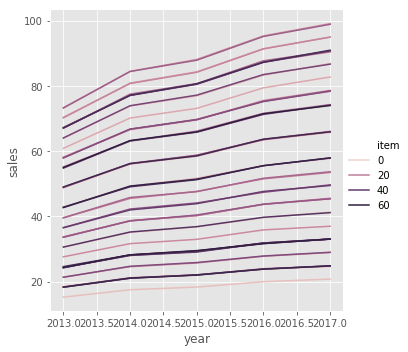

In [15]:
# unique(train$item)
# Year_state<-aggregate(sales ~item+Year, train,mean)
data = train.groupby(['item',"year"])
mean = data[["sales"]].mean()
mean = mean.add_suffix('').reset_index()
g = sns.relplot(y="sales", x="year", data=mean, kind="line", hue="item")

# 5. Prophet Model

## 5.4 Building the model for store = 1, product = 1

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
s1i1 = train[(train["store"]==1) & (train["item"])==1]
s1i1["sales"] = np.log1p(s1i1["sales"])
s1i1.head()

,date,store,item,sales,year,month,month_year
0,2013-01-01,1,1,2.639057,2013,1,2013-01
1,2013-01-02,1,1,2.484907,2013,1,2013-01
2,2013-01-03,1,1,2.708050,2013,1,2013-01
3,2013-01-04,1,1,2.639057,2013,1,2013-01
4,2013-01-05,1,1,2.397895,2013,1,2013-01


In [18]:
# R script: stats=aggregate(stats$y,by=list(stats$ds),FUN=sum)
# R script: MSP <- aggregate(sales ~Year, train, mean)
stats = s1i1[["date", "sales"]]
stats.columns = ["ds", "y"]
stats.head()

,ds,y
0,2013-01-01,2.639057
1,2013-01-02,2.484907
2,2013-01-03,2.708050
3,2013-01-04,2.639057
4,2013-01-05,2.397895


In [19]:
m = Prophet()
m.fit(stats)
future = m.make_future_dataframe(periods=365)
future.tail()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
46010,2018-12-27
46011,2018-12-28
46012,2018-12-29
46013,2018-12-30
46014,2018-12-31


In [20]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
46010,2018-12-27,3.540741,2.844206,4.190111
46011,2018-12-28,3.603417,2.992219,4.252274
46012,2018-12-29,3.666285,3.072416,4.323417
46013,2018-12-30,3.721605,3.034707,4.354711
46014,2018-12-31,3.318168,2.658185,3.936207


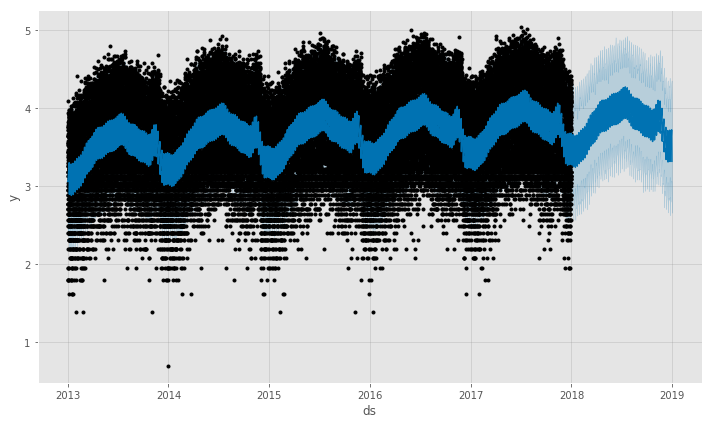

In [21]:
fig1 = m.plot(forecast)

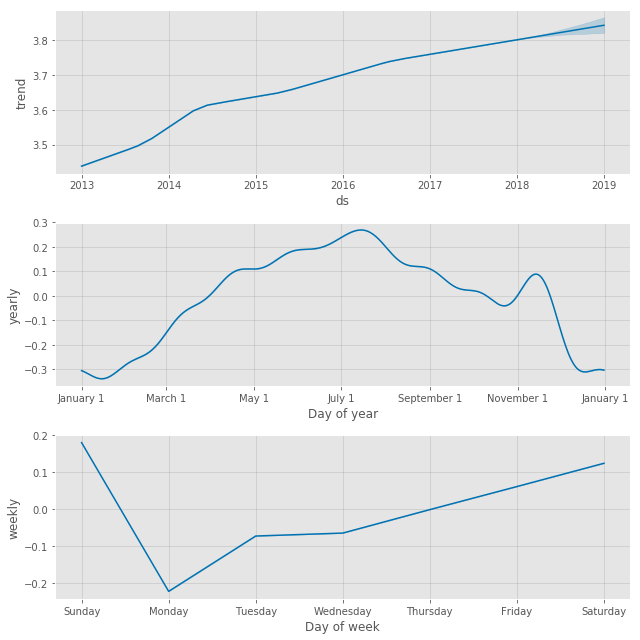

In [22]:
fig2 = m.plot_components(forecast)

We see sales drop from Sunday to Monday so there must be a holiday effect in the sales data. There's a peak in July so this may be due to seasonal sales or summer festivities.

Next step, try excluding change points and include holiday effects. Let's count NFL playoffs as a holiday. And add an extra regressor for NFL sundays.

In [23]:
playoffs = ['2013-07-12', '2014-07-12', '2014-07-19',
                 '2014-07-02', '2015-07-11', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24']
superbowl = ['2013-01-01', '2013-12-25', '2014-01-01', '2014-12-25','2015-01-01', '2015-12-25','2016-01-01', '2016-12-25',
                '2017-01-01', '2017-12-25']

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(playoffs),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(superbowl),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [24]:
s1i1["dow"] = pd.to_datetime(s1i1["date"]).dt.day_name() # day of week
s1i1.head()

,date,store,item,sales,year,month,month_year,dow
0,2013-01-01,1,1,2.639057,2013,1,2013-01,Tuesday
1,2013-01-02,1,1,2.484907,2013,1,2013-01,Wednesday
2,2013-01-03,1,1,2.708050,2013,1,2013-01,Thursday
3,2013-01-04,1,1,2.639057,2013,1,2013-01,Friday
4,2013-01-05,1,1,2.397895,2013,1,2013-01,Saturday


In [25]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

In [26]:
stats = s1i1[["date", "sales"]]
stats.columns = ["ds", "y"]
stats.head()

,ds,y
0,2013-01-01,2.639057
1,2013-01-02,2.484907
2,2013-01-03,2.708050
3,2013-01-04,2.639057
4,2013-01-05,2.397895


In [27]:
stats["nfl_sunday"] = stats['ds'].apply(nfl_sunday)
stats.head()

,ds,y,nfl_sunday
0,2013-01-01,2.639057,0
1,2013-01-02,2.484907,0
2,2013-01-03,2.708050,0
3,2013-01-04,2.639057,0
4,2013-01-05,2.397895,0


In [28]:
# R script below:
#model_prophet <- prophet()
#model_prophet <- add_regressor(model_prophet, 'nfl_sunday')
#model_prophet <- add_seasonality(model_prophet, name='daily', period=60, fourier.order=5)
#model_prophet <- prophet(stats, holidays = holidays,holidays.prior.scale = 0.5, yearly.seasonality = 4,
#                         interval.width = 0.95,changepoint.prior.scale = 0.006,daily.seasonality = T)
#future = make_future_dataframe(model_prophet, periods = 90, freq = 'days')
#forecast = predict(model_prophet, future)
m = Prophet(holidays=holidays, holidays_prior_scale=0.5,
            yearly_seasonality=4,  interval_width=0.95,
            changepoint_prior_scale=0.006, daily_seasonality=True)
m.add_regressor('nfl_sunday')
m.add_seasonality(name='daily', period=60, fourier_order=5)
m.fit(stats)

In [29]:
future = m.make_future_dataframe(periods=90, freq="D") # Daily frequency
future['nfl_sunday'] = future['ds'].apply(nfl_sunday)
future.tail()

,ds,nfl_sunday
45735,2018-03-27,0
45736,2018-03-28,0
45737,2018-03-29,0
45738,2018-03-30,0
45739,2018-03-31,0


In [30]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
45735,2018-03-27,3.740169,2.748041,4.744733
45736,2018-03-28,3.752492,2.718027,4.873305
45737,2018-03-29,3.820259,2.807089,4.766746
45738,2018-03-30,3.887055,2.927746,4.912121
45739,2018-03-31,3.954198,3.029688,4.973436


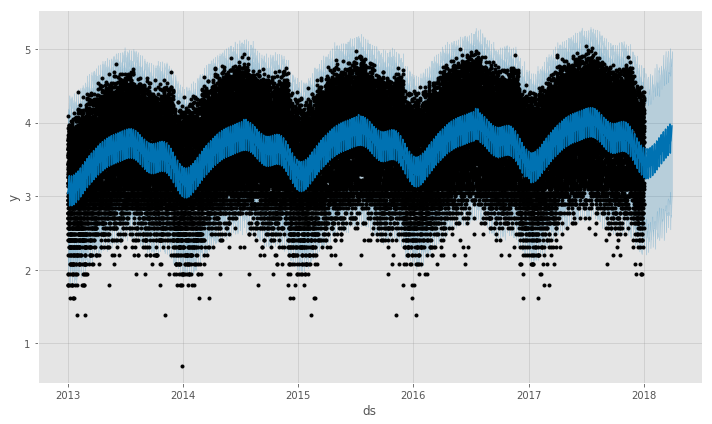

In [31]:
fig1 = m.plot(forecast)

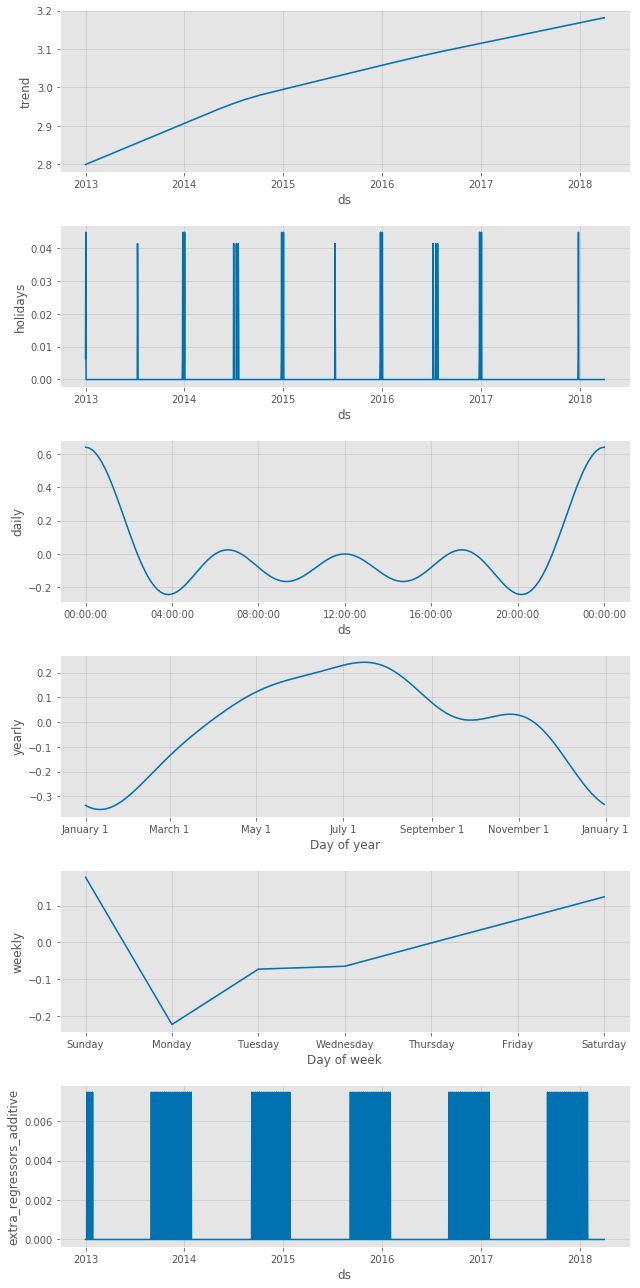

In [32]:
fig2 = m.plot_components(forecast)

Things are a lot smoother now. Note that in the original kernel, I believe that "NFL Sundays" wasn't included in the future data- so the results look slightly different. This was raised in a comment and I believe it was confirmed by the author. 

# 5.8 SMAPE Calcuation

I'm not entirely sure if this recreation was done correctly- the results are different than in the original kernel, but that may be because of the error mentioned above.

In [33]:
# R script: predict_store1_item1=data.frame(date=forecast$ds,forecast=expm1(forecast$yhat))
# predict_store1_item1$yearmonth=as.yearmon(predict_store1_item1$date)
# colnames(predict_store1_item1)<-c("ds","forecast","yearmonth")
ps1i1 = forecast[["ds"]]
ps1i1["forecast"] = np.expm1(forecast["yhat"])
ps1i1["yearmonth"] = pd.to_datetime(ps1i1["ds"]).dt.to_period("M")
ps1i1.head()

,ds,forecast,yearmonth
0,2013-01-01,19.858588,2013-01
1,2013-01-01,19.858588,2013-01
2,2013-01-01,19.858588,2013-01
3,2013-01-01,19.858588,2013-01
4,2013-01-01,19.858588,2013-01


In [34]:
def smape(outsample, forecast):
    num = np.abs(outsample-forecast)
    denom = np.abs(outsample) + np.abs(forecast)
    return (num/denom)/2

stats["ds"] = pd.to_datetime(stats["ds"])

In [35]:
ps1i1["ds"] = pd.to_datetime(ps1i1["ds"])

In [36]:
# R script: train_predict = merge(stats, ps1i1, by = "ds", all.x=T)
train_predict = stats.merge(ps1i1)

In [37]:
smape_err = smape(train_predict["y"], train_predict["forecast"])
smape_err = smape_err[~np.isnan(smape_err)]
np.mean(smape_err)

0.41069958670841406

As mentioned, this value is different than in the kernel I'm reproducing.

# 5.9 Automated forecasting with Prophet: Splitting data by store and item

In [38]:
# Training data from the very beginning
# Note that I've added some columns
train["sales"] = np.log1p(train["sales"]) 

In [39]:
train.columns = ["ds", "store", "item", "sales", "y", "m", "my"]
train.head()

,ds,store,item,sales,y,m,my
0,2013-01-01,1,1,2.639057,2013,1,2013-01
1,2013-01-02,1,1,2.484907,2013,1,2013-01
2,2013-01-03,1,1,2.708050,2013,1,2013-01
3,2013-01-04,1,1,2.639057,2013,1,2013-01
4,2013-01-05,1,1,2.397895,2013,1,2013-01


In [40]:
def make_prediction(df):
    
    playoffs = ['2013-07-12', '2014-07-12', '2014-07-19',
                 '2014-07-02', '2015-07-11', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24']
    superbowl = ['2013-01-01', '2013-12-25', '2014-01-01', '2014-12-25','2015-01-01', '2015-12-25','2016-01-01', '2016-12-25',
                    '2017-01-01', '2017-12-25']

    playoffs = pd.DataFrame({
      'holiday': 'playoff',
      'ds': pd.to_datetime(playoffs),
      'lower_window': 0,
      'upper_window': 1,
    })
    superbowls = pd.DataFrame({
      'holiday': 'superbowl',
      'ds': pd.to_datetime(superbowl),
      'lower_window': 0,
      'upper_window': 1,
    })
    holidays = pd.concat((playoffs, superbowls))
    
    m = Prophet(holidays=holidays, holidays_prior_scale=0.5,
            yearly_seasonality=4,  interval_width=0.95,
            changepoint_prior_scale=0.006, daily_seasonality=True)
    m.add_seasonality(name='daily', period=60, fourier_order=5)
    m.fit(df)
    future = m.make_future_dataframe(periods=90)
    forecast = m.predict(future)
    return forecast

In [41]:
df = train[(train["store"]==1) & (train["item"] ==2)]
df = df[["ds", "sales"]]
df.columns = ["ds", "y"]
df.head()

,ds,y
18260,2013-01-01,3.526361
18261,2013-01-02,3.784190
18262,2013-01-03,3.178054
18263,2013-01-04,2.944439
18264,2013-01-05,3.555348


In [42]:
prediction = make_prediction(df)
prediction[["ds", "yhat"]].tail()

,ds,yhat
1911,2018-03-27,4.046666
1912,2018-03-28,4.064857
1913,2018-03-29,4.128025
1914,2018-03-30,4.188482
1915,2018-03-31,4.258744
